In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns

In [173]:
df=pd.read_csv("dynamic_pricing 4.csv")
df

,Products,Avg_Price_per_unit,Cost_per_unit,Average_Profit_per_unit,Average_units_sold,Incremental_acquisition,Increase_sale_volume
0,Product 1,95,92,2.8,0.6,0.00323,0.08906
1,Product 2,37,27,10.0,0.8,0.00106,0.01991
2,Product 3,34,26,8.5,0.6,0.00328,0.03778
3,Product 4,32,30,2.8,0.7,0.00000,0.08562
4,Product 5,62,45,16.0,1.0,0.00079,0.02637
...,...,...,...,...,...,...,...
245,Product 246,23,21,2.0,1.5,0.00290,0.07129
246,Product 247,59,57,1.5,0.5,0.00000,0.05905
247,Product 248,16,15,0.9,1.6,0.00095,0.04835
248,Product 249,84,71,13.2,0.8,0.00264,0.00473


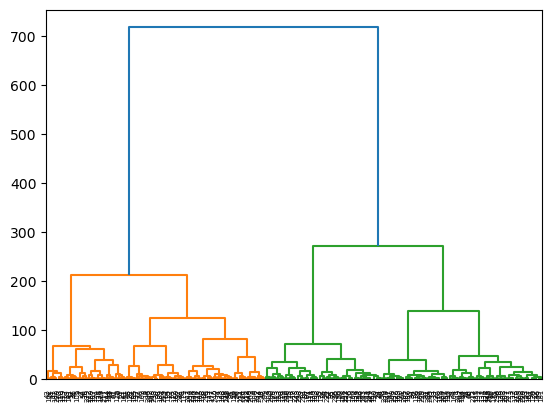

In [174]:
linkage_data = linkage(df.select_dtypes('number'), method='ward', metric='euclidean')
labels = fcluster(linkage_data, t=2, criterion='maxclust')
df['cluster']=labels-1
_=dendrogram(linkage_data)

In [175]:
df['pred']=float('nan')
df

,Products,Avg_Price_per_unit,Cost_per_unit,Average_Profit_per_unit,Average_units_sold,Incremental_acquisition,Increase_sale_volume,cluster,pred
0,Product 1,95,92,2.8,0.6,0.00323,0.08906,0,NaN
1,Product 2,37,27,10.0,0.8,0.00106,0.01991,1,NaN
2,Product 3,34,26,8.5,0.6,0.00328,0.03778,1,NaN
3,Product 4,32,30,2.8,0.7,0.00000,0.08562,1,NaN
4,Product 5,62,45,16.0,1.0,0.00079,0.02637,1,NaN
...,...,...,...,...,...,...,...,...,...
245,Product 246,23,21,2.0,1.5,0.00290,0.07129,1,NaN
246,Product 247,59,57,1.5,0.5,0.00000,0.05905,1,NaN
247,Product 248,16,15,0.9,1.6,0.00095,0.04835,1,NaN
248,Product 249,84,71,13.2,0.8,0.00264,0.00473,0,NaN


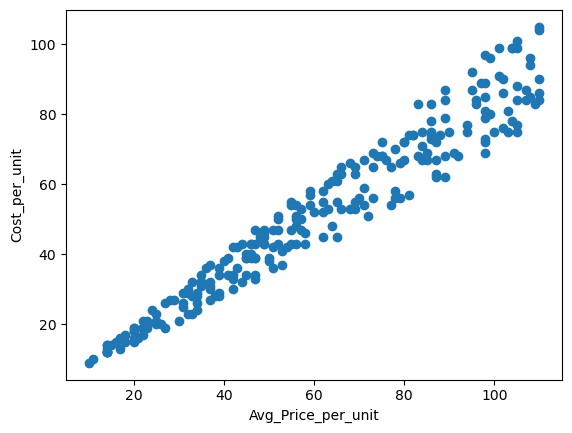

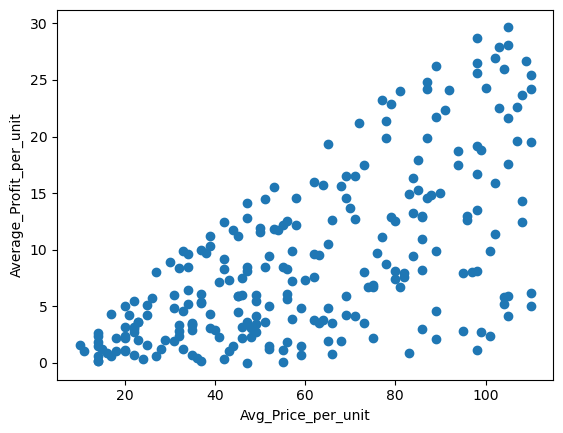

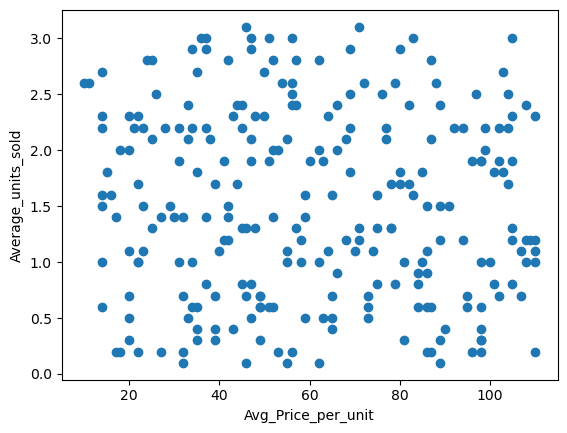

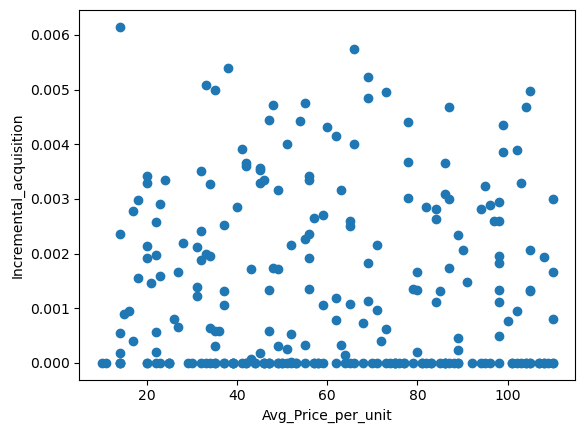

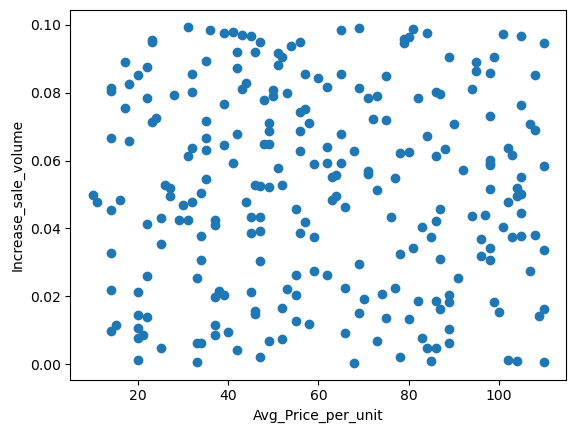

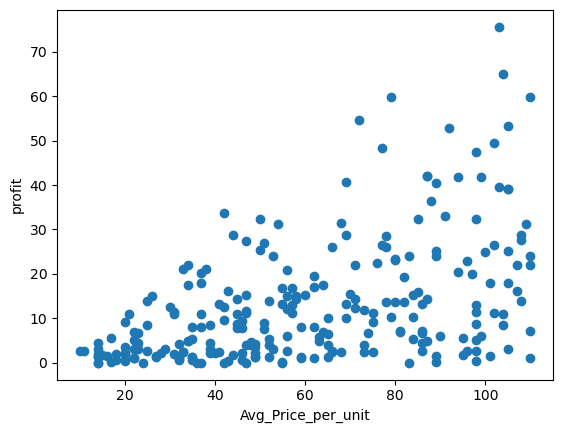

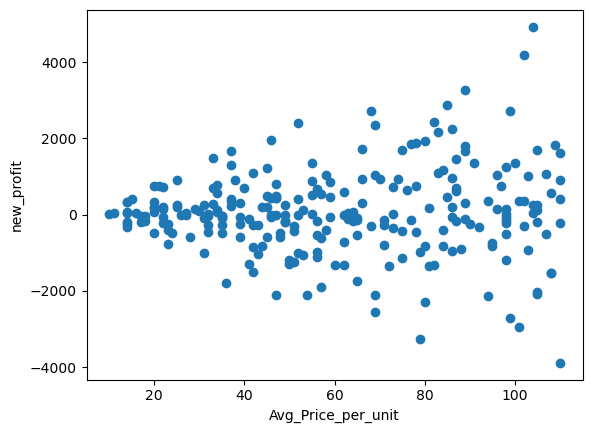

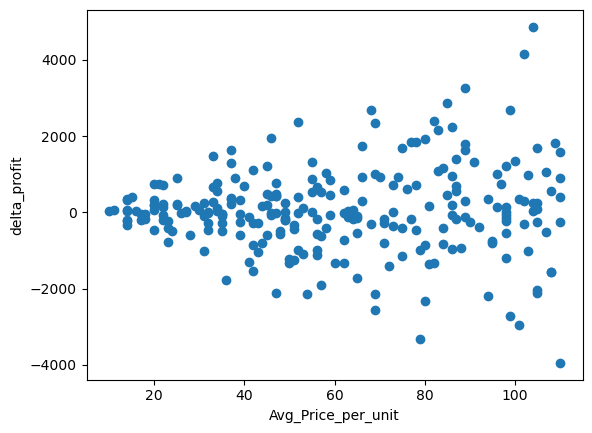

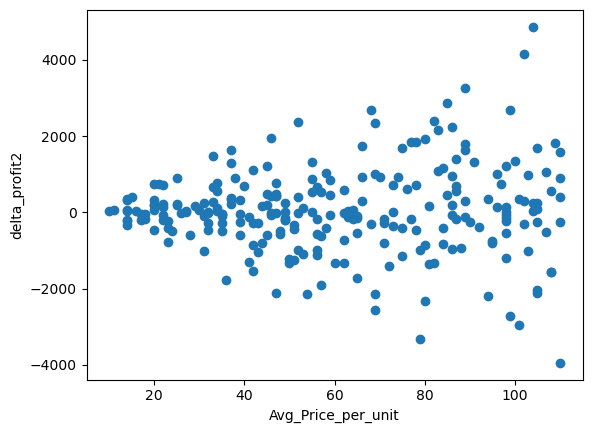

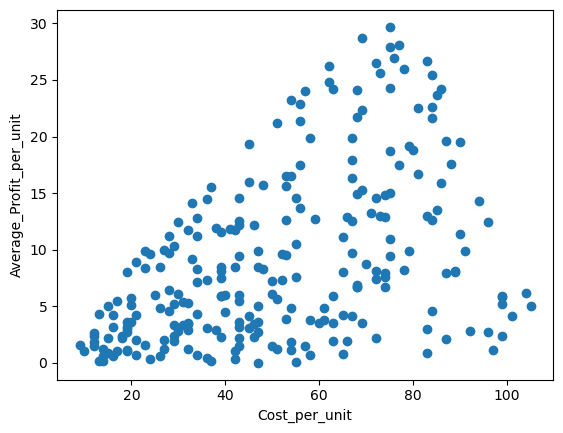

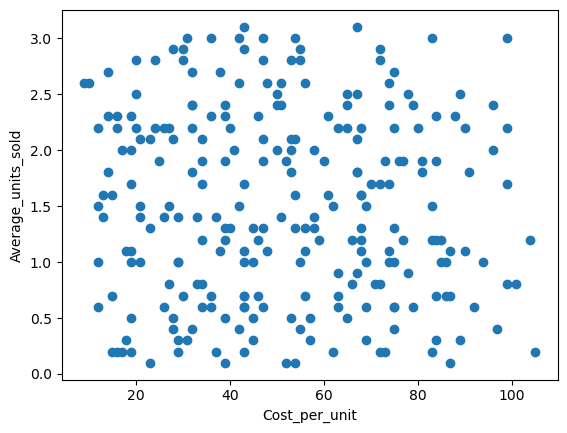

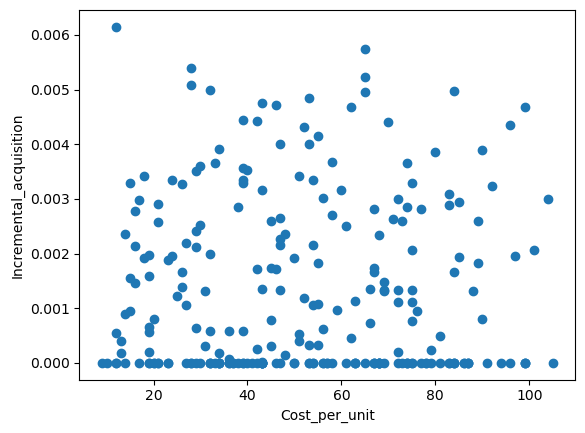

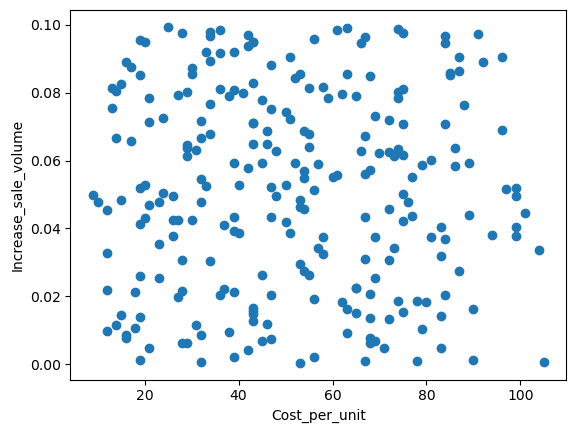

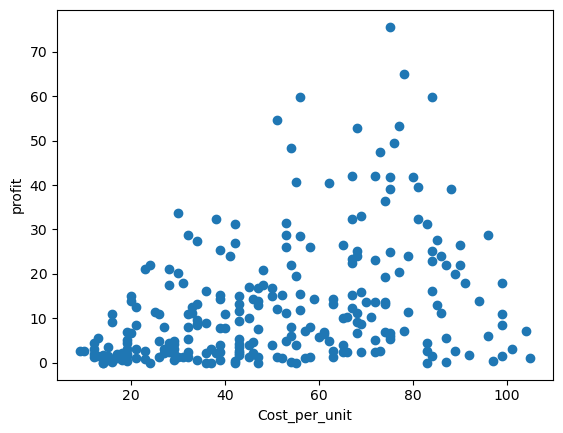

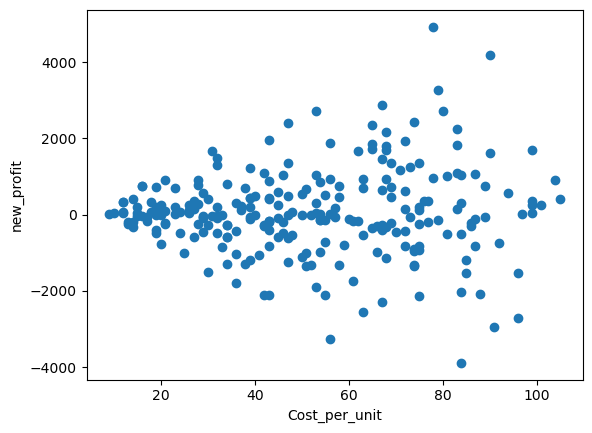

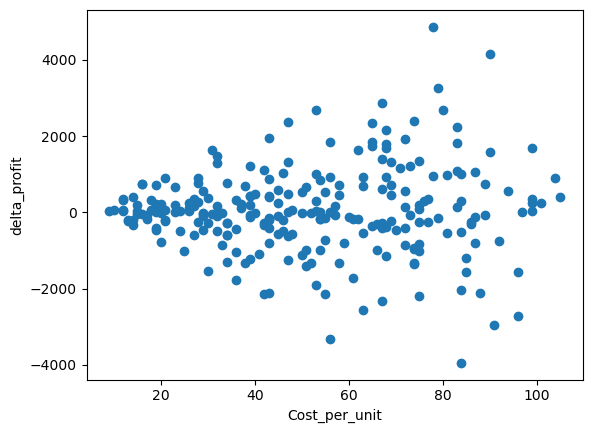

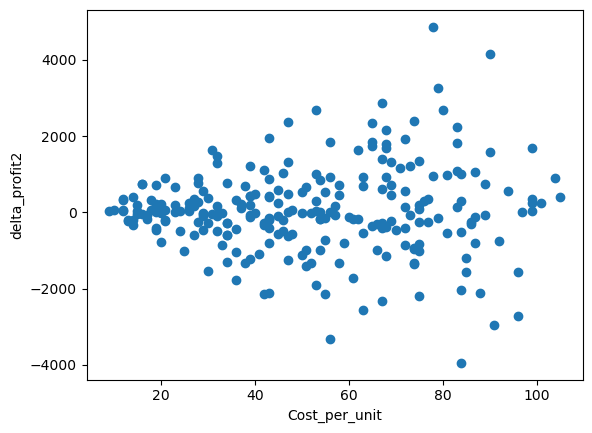

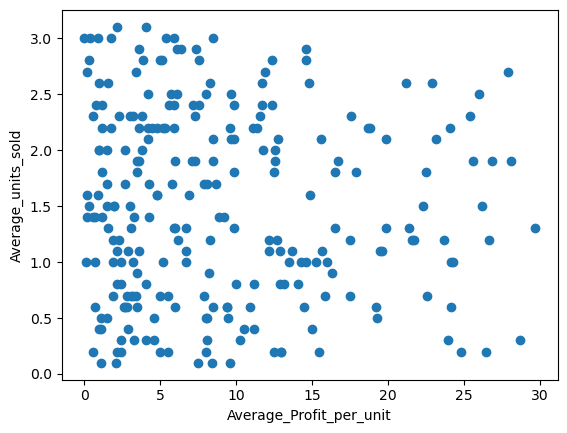

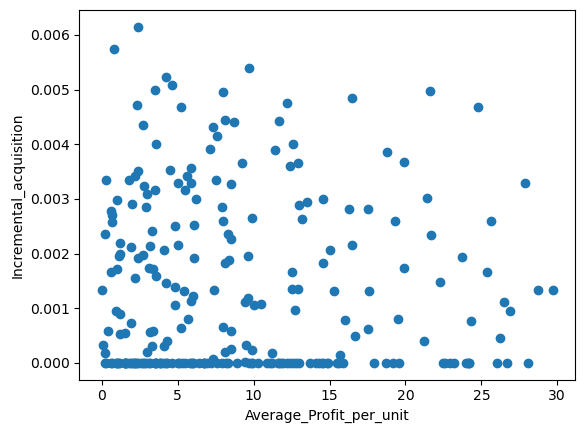

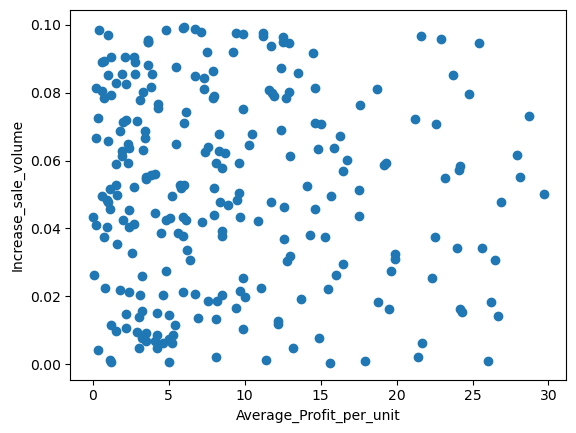

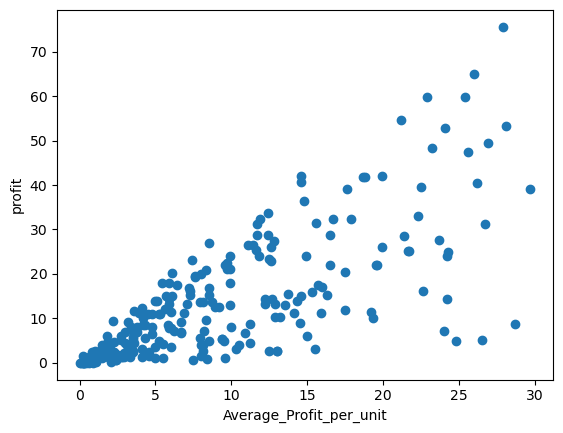

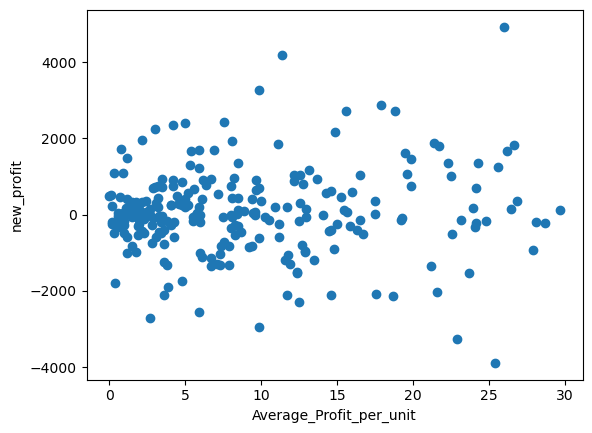

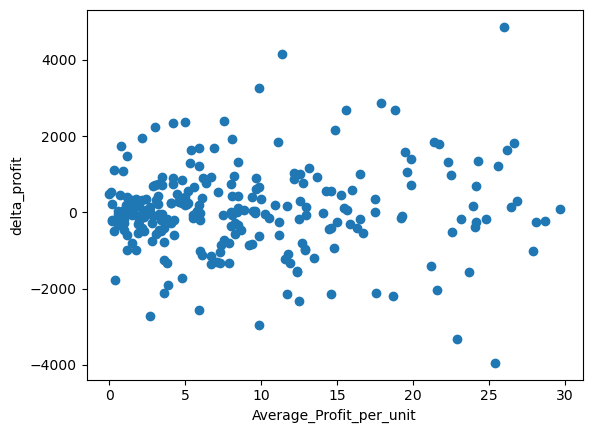

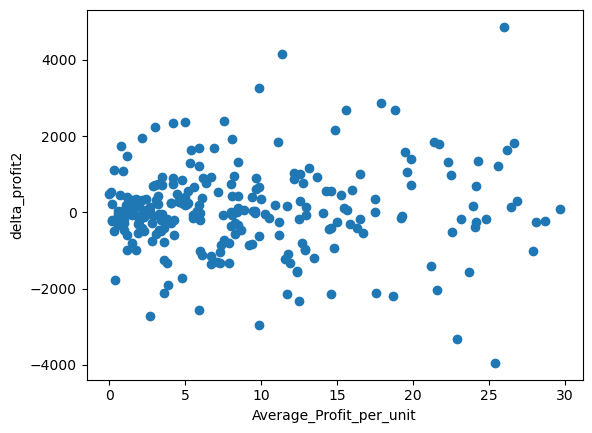

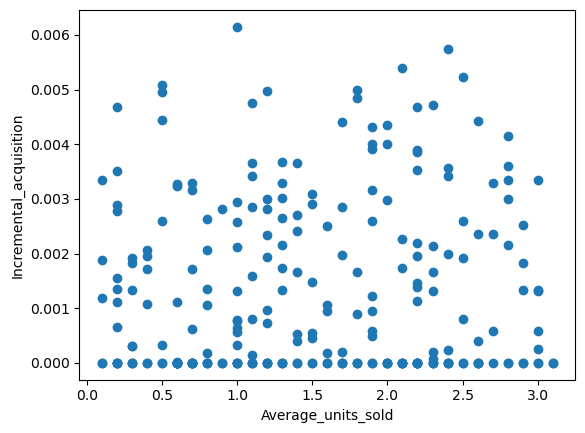

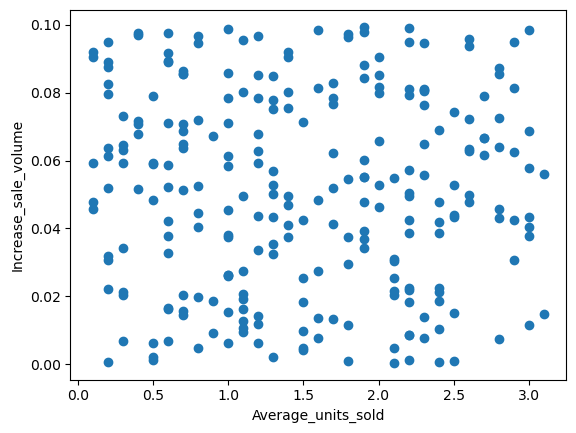

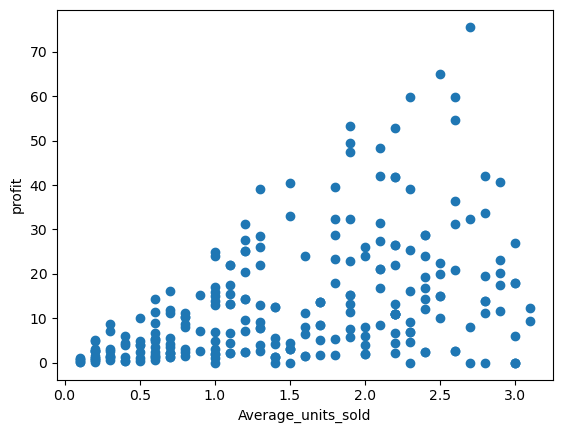

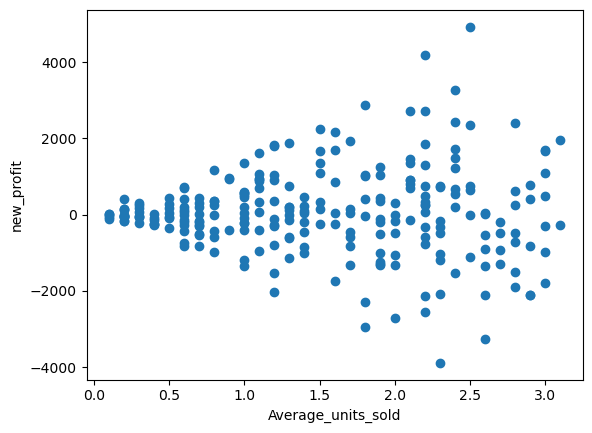

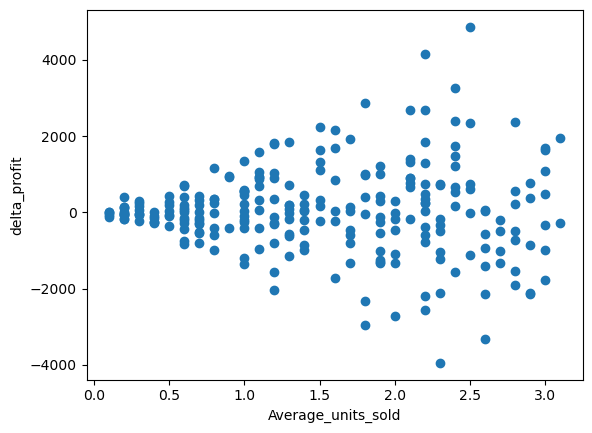

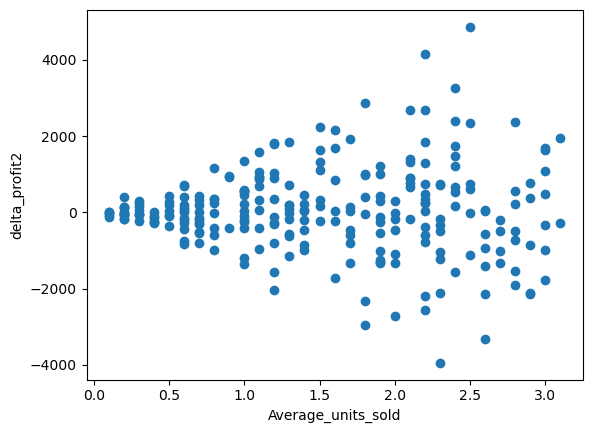

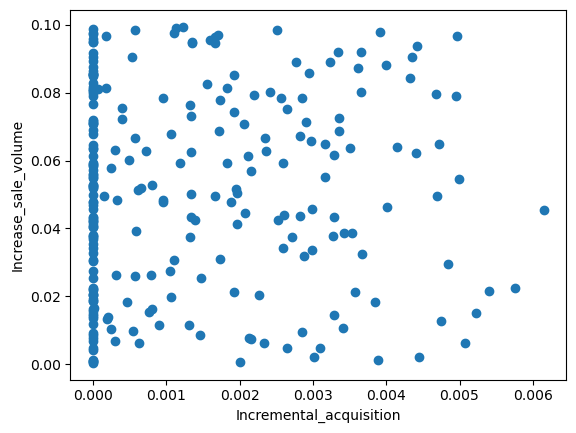

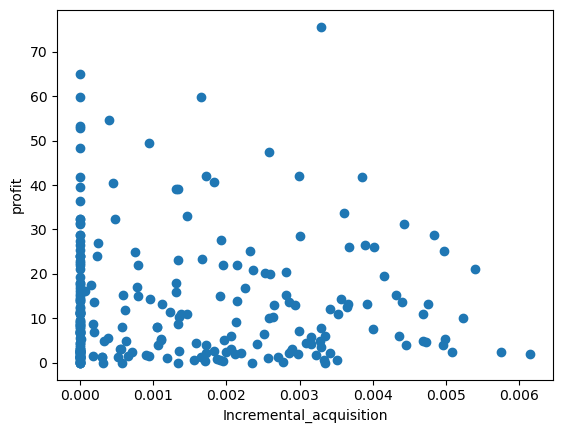

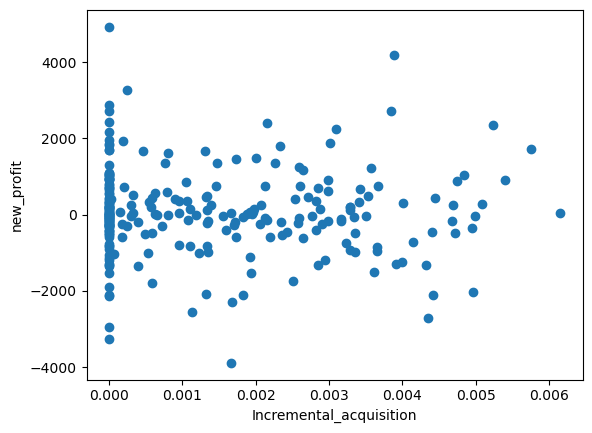

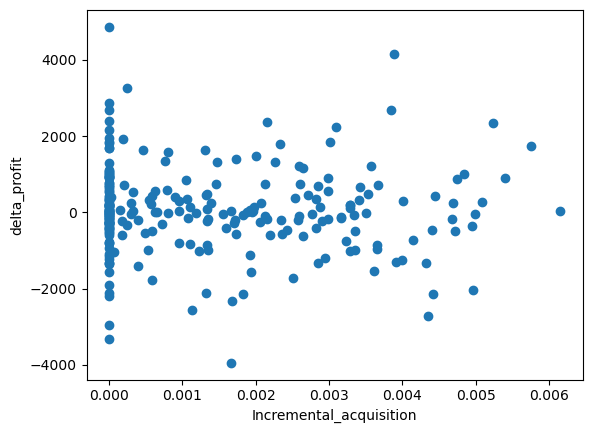

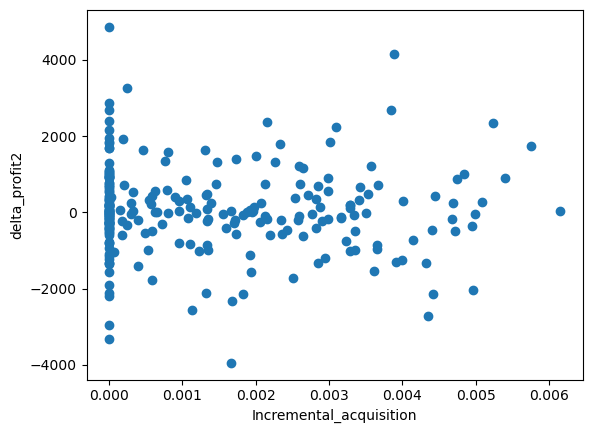

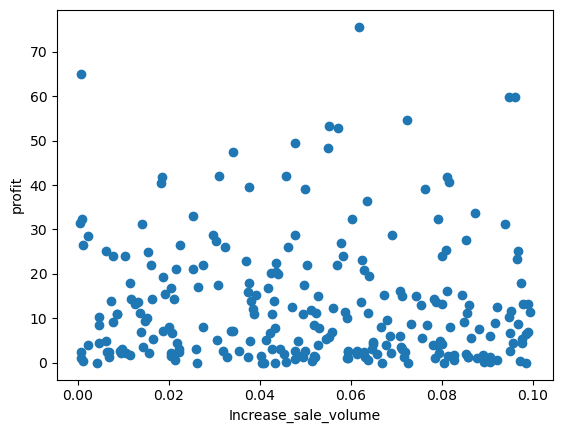

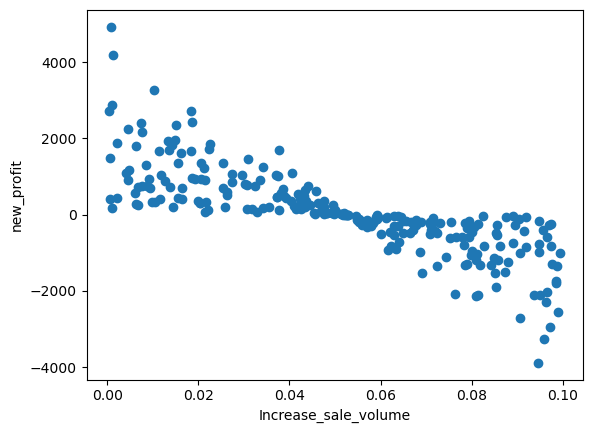

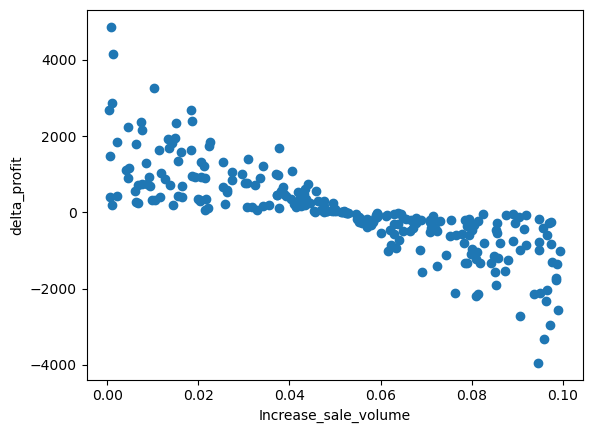

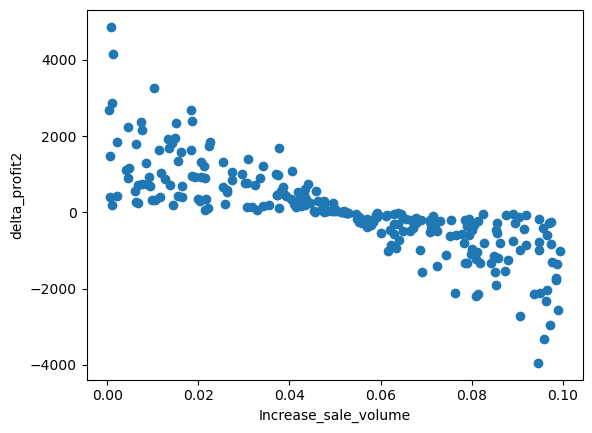

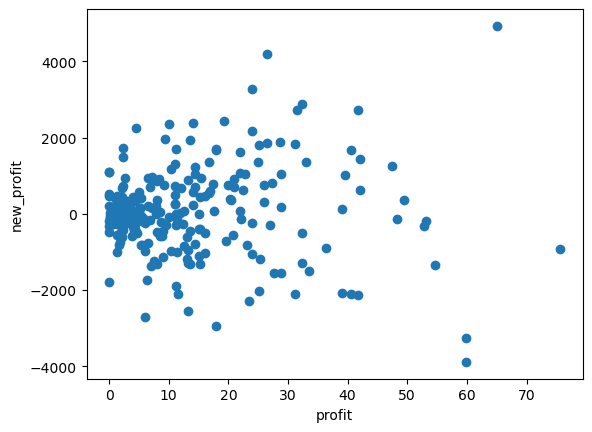

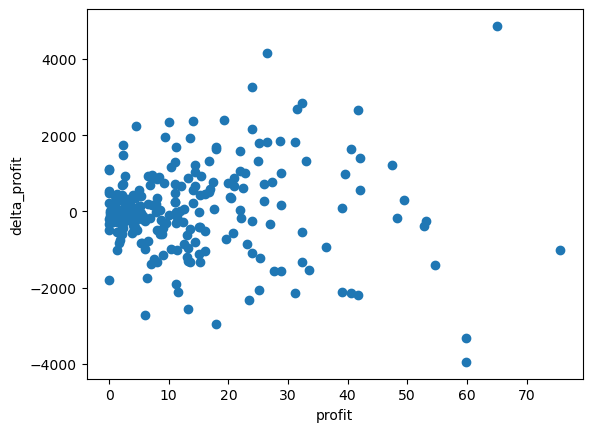

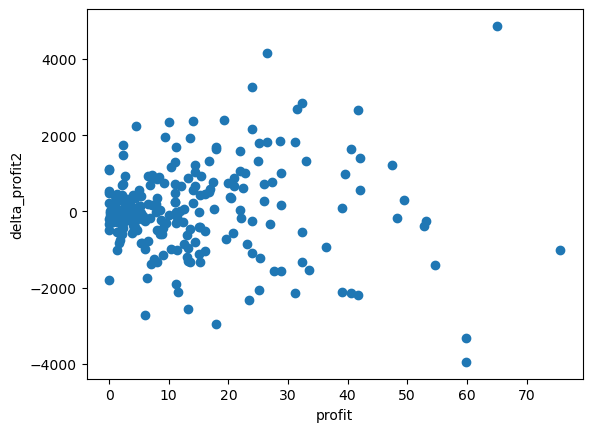

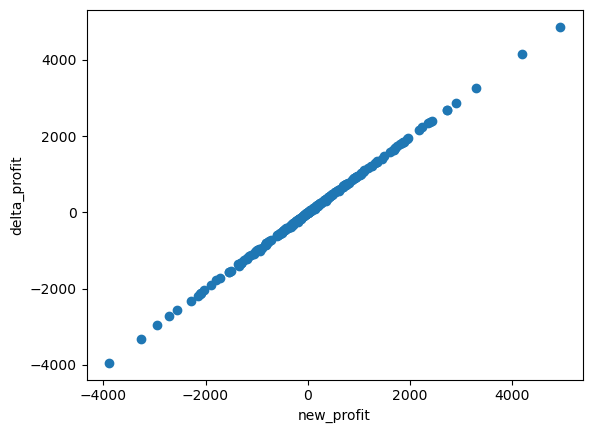

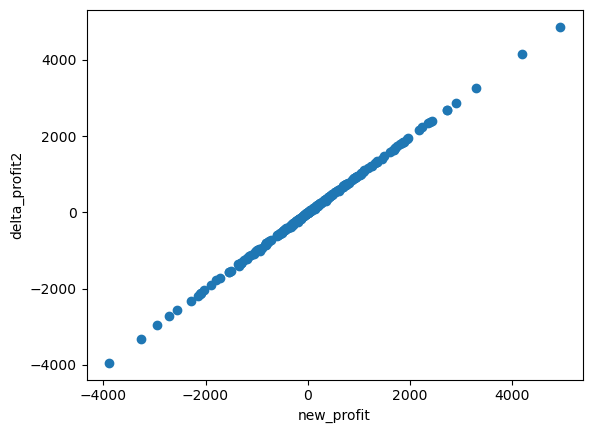

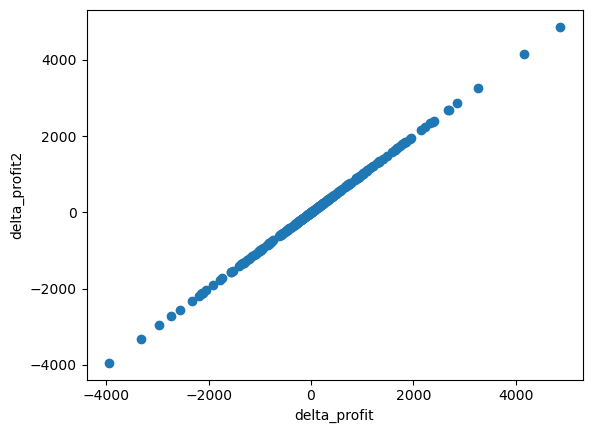

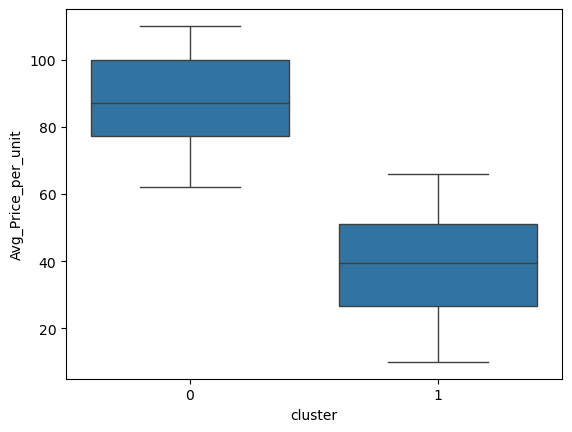

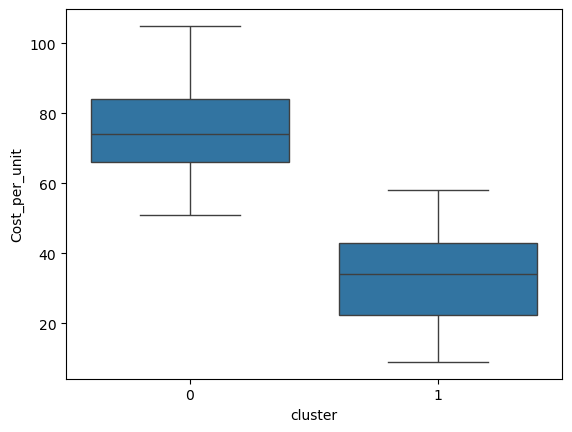

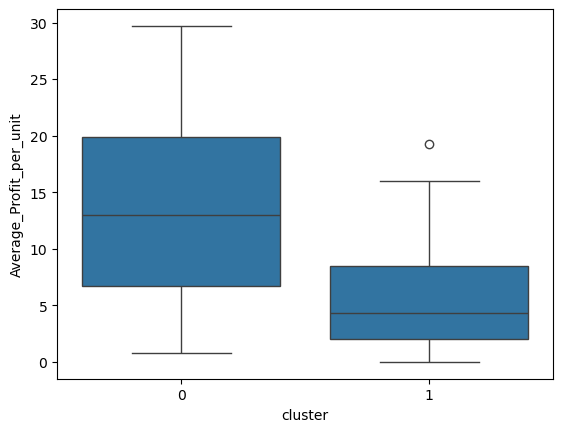

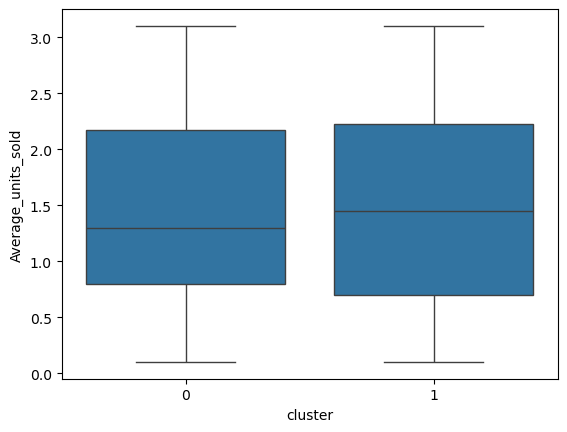

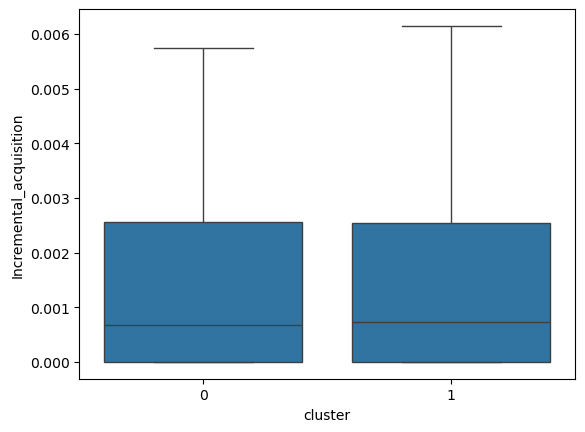

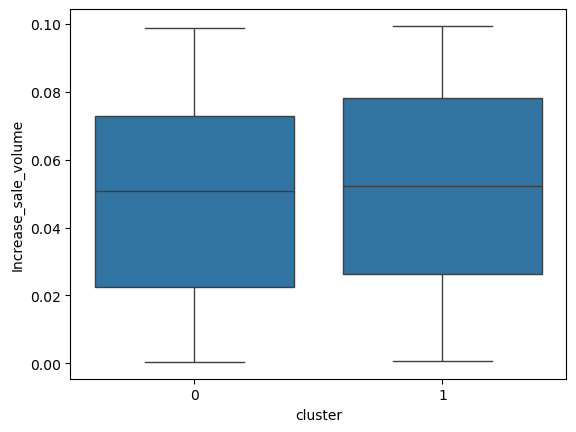

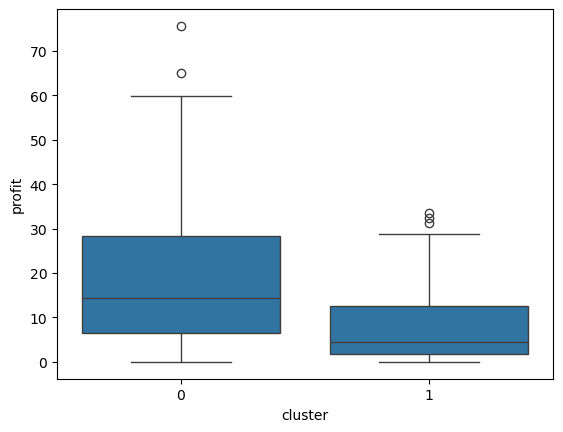

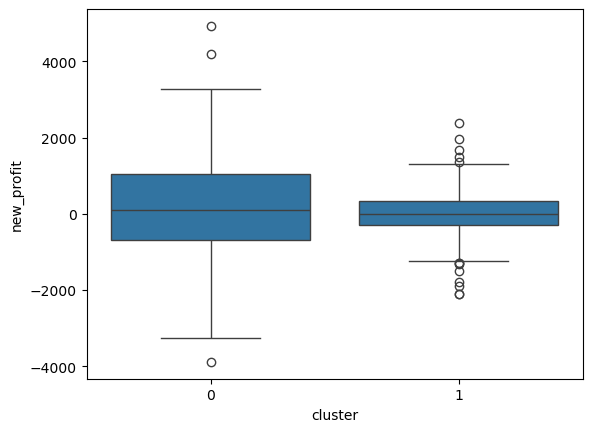

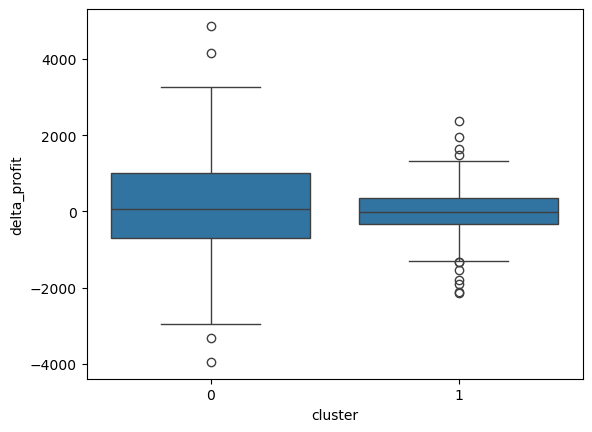

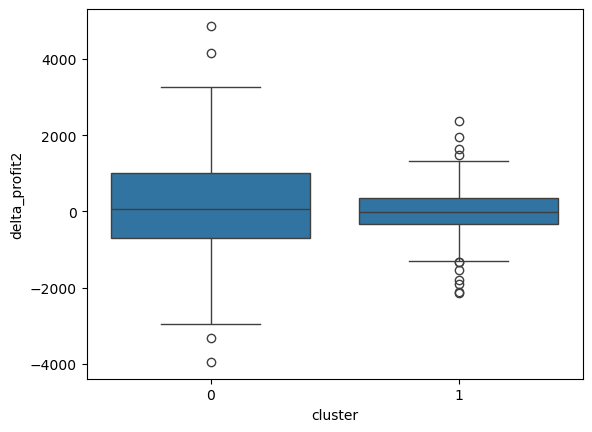

In [23]:
col=list(df.select_dtypes('number'))
col.remove("cluster")
col.append("cluster")
for i in range(len(col)-2):
    for j in range(i+1,len(col)-1):
        plt.scatter(df[col[i]],df[col[j]])
        plt.xlabel(col[i])
        plt.ylabel(col[j])
        plt.show()
for i in range(len(col)-1):
    sns.boxplot(data=df,x=col[-1],y=col[i])
    plt.show()

In [66]:
import torch
from torch import nn
from tqdm.auto import tqdm

In [242]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(7,512),
            nn.SiLU(),
            nn.Linear(512,64),
            nn.SiLU(),
            nn.Linear(64,1)
        )
    def forward(self, x):
        return self.layers(x)

In [243]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(8,512),
            nn.SiLU(),
            nn.Linear(512,64),
            nn.SiLU(),
            nn.Linear(64,1)
        )
    def forward(self, x):
        return self.layers(x)

In [244]:
class ActorCriticModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.actor=Actor()
        self.critic=Critic()#value network
    def forward(self, 
        Avg_Price_per_unit,
        Cost_per_unit,
        Average_Profit_per_unit,
        Average_units_sold,
        Incremental_acquisition,
        Increase_sale_volume,
        cluster
       ):
        X=torch.tensor([
            Avg_Price_per_unit,
            Cost_per_unit,
            Average_Profit_per_unit,
            Average_units_sold,
            Incremental_acquisition,
            Increase_sale_volume,
            cluster
        ]).view(1,-1)
        act=self.actor(X)
        act_in=torch.cat((X,act),-1)
        return act,self.critic(act_in)

In [247]:
model=ActorCriticModel()
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0005)
global_iters=0
epochs=100
_critic_loss=0.0
_actor_loss=0.0
iterator=tqdm(range(epochs))
for epoch in iterator:
    for i,row in df.iterrows():
        global_iters+=1
        #train critic
        for param in model.actor.parameters():
            param.requires_grad = False
        actor_out, critic_out = model(
            (row['Avg_Price_per_unit']-60.62)/28.318959,
            (row['Cost_per_unit']-51.596000)/24.182223,
            (row['Average_Profit_per_unit']-9.034400)/7.433913,
            (row['Average_units_sold']-1.500400)/0.839511,
            (row['Incremental_acquisition']-0.001366)/0.001579,
            (row['Increase_sale_volume']-0.050986)/0.029084,
            (row['cluster']-0.560000)/0.497383
        )
        #print("A:",actor_out, critic_out)
        relative_delta_price = actor_out
        APU=row['Avg_Price_per_unit']
        CPU=row['Cost_per_unit']
        AUS=row['Average_units_sold']
        ISV=row['Increase_sale_volume']
        RDP=relative_delta_price
        profit=(APU-CPU)*AUS
        new_profit=(APU*(1+RDP)-CPU)*(AUS*(1-ISV*RDP))
        relative_delta_profit=new_profit
        if torch.isnan(relative_delta_profit):
            print("FOUND NAN",APU,CPU,AUS,ISV,RDP.item())
            break
        if torch.isnan(critic_out):
            print("FOUND NAN2",APU,CPU,AUS,ISV,RDP.item())
            break
        critic_loss=torch.mean((critic_out-relative_delta_profit).abs())
        #print("critic_loss:",critic_loss)
        _critic_loss=float(critic_loss)*0.01+_critic_loss*0.99
        model.zero_grad(set_to_none=False)
        critic_loss.backward()
        optimizer.step()
        for param in model.actor.parameters():
            param.requires_grad = True


        #train actor
        if global_iters>10_000 and global_iters%17==0:
            for param in model.critic.parameters():
                param.requires_grad = False
            actor_out, critic_out = model(
                (row['Avg_Price_per_unit']-60.62)/28.318959,
                (row['Cost_per_unit']-51.596000)/24.182223,
                (row['Average_Profit_per_unit']-9.034400)/7.433913,
                (row['Average_units_sold']-1.500400)/0.839511,
                (row['Incremental_acquisition']-0.001366)/0.001579,
                (row['Increase_sale_volume']-0.050986)/0.029084,
                (row['cluster']-0.560000)/0.497383
            )
            #print("B:",actor_out, critic_out)
            actor_loss=-critic_out
            _actor_loss=float(actor_loss)*0.01+_actor_loss*0.99
            iterator.set_description(f"{_actor_loss:06.3f}:{float(actor_out):06.3f} {_critic_loss:06.3f}:{float(critic_out):06.3f}")
            model.zero_grad(set_to_none=True)
            actor_loss.backward()
            optimizer.step()
            for param in model.critic.parameters():
                param.requires_grad = True

  0%|          | 0/100 [00:00<?, ?it/s]

In [261]:
df['pred'].mean()

5.214698529243469

In [249]:
for i,row in df.iterrows():
    with torch.no_grad():
        actor_out, critic_out = model(
            (row['Avg_Price_per_unit']-60.62)/28.318959,
            (row['Cost_per_unit']-51.596000)/24.182223,
            (row['Average_Profit_per_unit']-9.034400)/7.433913,
            (row['Average_units_sold']-1.500400)/0.839511,
            (row['Incremental_acquisition']-0.001366)/0.001579,
            (row['Increase_sale_volume']-0.050986)/0.029084,
            (row['cluster']-0.560000)/0.497383
        )
        df.at[i,'pred']=float(actor_out)

In [250]:

APU=df['Avg_Price_per_unit']
CPU=df['Cost_per_unit']
AUS=df['Average_units_sold']
ISV=df['Increase_sale_volume']
RDP=df['pred']
# #df['profit']=(df['Avg_Price_per_unit']-df['Cost_per_unit'])*df['Average_units_sold']
# #df['new_profit']=(df['Avg_Price_per_unit']*(1+delta_price)-df['Cost_per_unit'])*(df['Average_units_sold']*(1-df['Increase_sale_volume']*delta_price))
# #df['delta_profit']=df['new_profit']-df['profit']
# #df['delta_profit2']=DP*AUS*(APU*(1-ISV*(1+DP))+CPU*ISV)
# #API*AUS*(DP*(1-ISV)-ISV*DP*DP)+CPU*AUS*ISV*DP
# __profit=(APU-CPU)*AUS
# __new_profit=(APU*(1+DP)-CPU)*(AUS*(1-ISV*DP))
# __pred1=__new_profit/__profit
# __pred2=(APU*(1+DP)-CPU)*(AUS*(1-ISV*DP))/((APU-CPU)*AUS)
profit=(APU-CPU)*AUS
df['profit']=profit
new_profit=(APU*(1+RDP)-CPU)*(AUS*(1-ISV*RDP))
df['new_profit']=new_profit
relative_delta_profit=(new_profit-profit)/(new_profit+profit)
df['score']=relative_delta_profit

In [256]:
df['profit'].mean()

13.143600000000001

In [257]:
df['new_profit'].mean()

370.5999743169586

In [260]:
df['new_profit'].mean()-df['profit'].mean()

357.4563743169586

In [259]:
(df['new_profit']-df['profit']).mean()

357.45637431695855

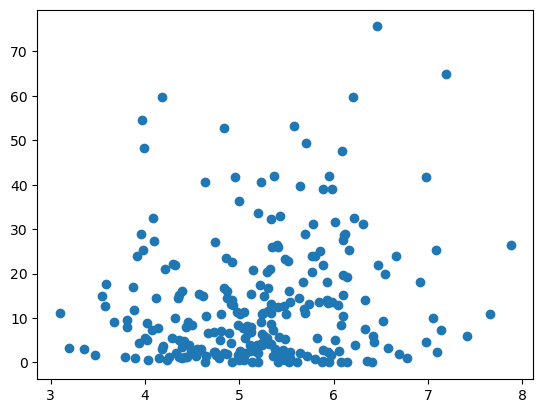

In [262]:
plt.scatter(df['pred'],df['profit'])

In [198]:
df['score'].sort_values()

89    -2.347219e+08
40    -1.957501e+08
31    -1.937217e+08
16    -1.594735e+08
23    -1.566975e+08
           ...     
129    8.868448e+01
166    2.641314e+03
14     4.769881e+03
20     5.385044e+03
29     7.033000e+03
Name: score, Length: 250, dtype: float64

In [93]:
model(
    (row['Avg_Price_per_unit']-60.62)/28.318959,
    (row['Cost_per_unit']-51.596000)/24.182223,
    (row['Average_Profit_per_unit']-9.034400)/7.433913,
    (row['Average_units_sold']-1.500400)/0.839511,
    (row['Incremental_acquisition']-0.001366)/0.001579,
    (row['Increase_sale_volume']-0.050986)/0.029084,
    (row['cluster']-0.560000)/0.497383
)

(tensor([[-0.0960]]), tensor([[nan]], grad_fn=<AddmmBackward0>))

In [81]:
critic_out

tensor([[0.0386]], grad_fn=<AddmmBackward0>)

In [70]:
actor_out, critic_out

(tensor([[nan]], grad_fn=<AddmmBackward0>),
 tensor([[nan]], grad_fn=<AddmmBackward0>))

<Axes: ylabel='Frequency'>

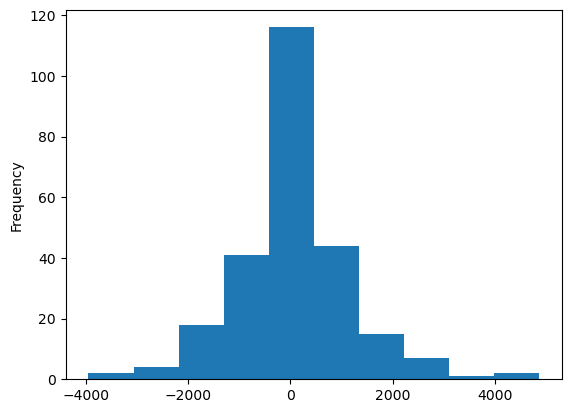

In [65]:
df['delta_profit'].plot.hist()

<Axes: ylabel='Frequency'>

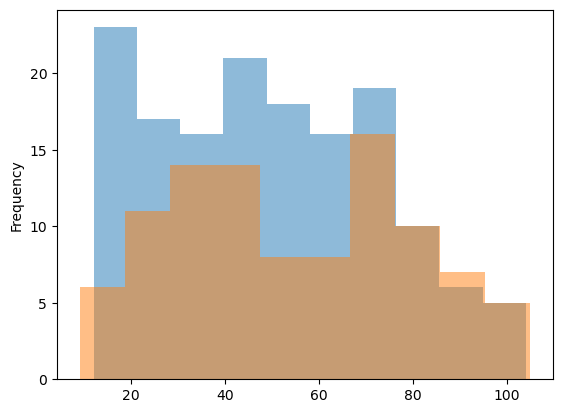

In [25]:

df.loc[df['Incremental_acquisition']!=0,'Cost_per_unit'].plot.hist(bins=10,alpha=0.5)
df.loc[df['Incremental_acquisition']==0,'Cost_per_unit'].plot.hist(bins=10,alpha=0.5)

<Axes: ylabel='Frequency'>

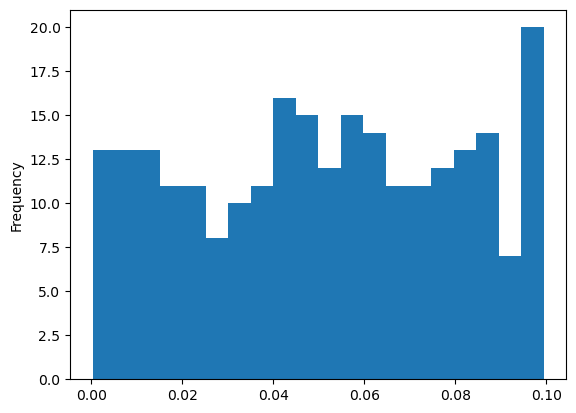

In [6]:
df['Increase_sale_volume'].plot.hist(bins=20)

<Axes: ylabel='Frequency'>

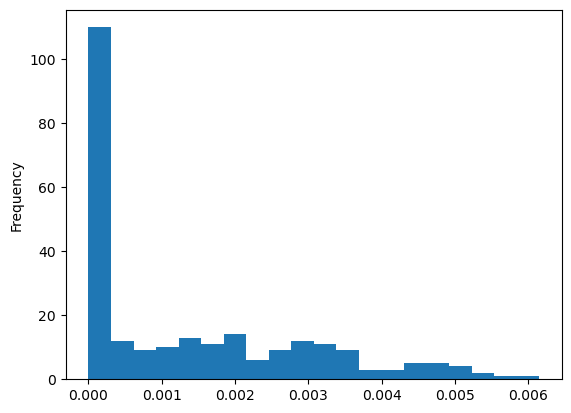

In [7]:
df['Incremental_acquisition'].plot.hist(bins=20)

In [14]:
df['Incremental_acquisition'].quantile([0,0.01,0.05,0.1,0.2,.25,.375,.38,.4,.425,.5])

0.000    0.000000
0.010    0.000000
0.050    0.000000
0.100    0.000000
0.200    0.000000
0.250    0.000000
0.375    0.000000
0.380    0.000000
0.400    0.000050
0.425    0.000233
0.500    0.000690
Name: Incremental_acquisition, dtype: float64